In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

data = pd.read_csv("../input/Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


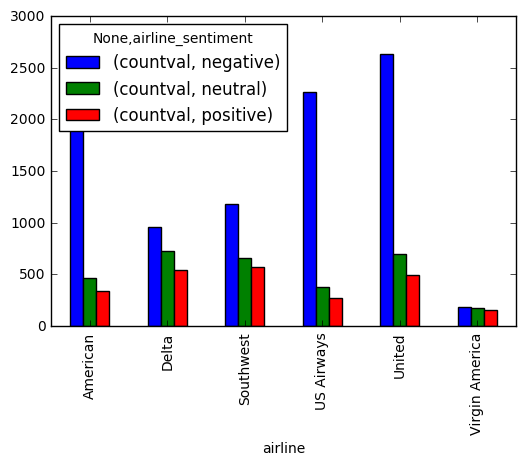

In [2]:
# Check the ratio of positive and negative tweets for each airline
data['countval'] = 1
groupby_object = data[['airline','airline_sentiment','countval']] \
                 .groupby(['airline','airline_sentiment']).aggregate(sum)
groupby_object.unstack(level=1).plot(kind='bar')
plt.show()

In [3]:
from nltk.corpus import stopwords
import re

# Define number of classes and number of tweets per class
n_class = 3
n_tweet = 3000

# Divide into number of classes
if n_class == 2:
    df_pos = data.copy()[data.airline_sentiment == 'positive'][:n_tweet]
    df_neg = data.copy()[data.airline_sentiment == 'negative'][:n_tweet]
    df_neu = pd.DataFrame()
    df = pd.concat([df_pos, df_neg], ignore_index=True).reset_index(drop=True)
elif n_class == 3:
    df_pos = data.copy()[data.airline_sentiment == 'positive'][:n_tweet]
    df_neg = data.copy()[data.airline_sentiment == 'negative'][:n_tweet]
    df_neu = data.copy()[data.airline_sentiment == 'neutral'][:n_tweet]
    df = pd.concat([df_pos, df_neg, df_neu], ignore_index=True).reset_index(drop=True)

def tweet_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = raw_review
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

processed_tweets = []
for tweet in data['text']:
    processed = tweet_to_words(tweet)
    processed_tweets.append(processed)

data["text"] = processed_tweets
# print(processed_tweets)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['airline_sentiment'], test_size=0.33, random_state=0)

df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train['text'] = X_train
df_train['airline_sentiment'] = y_train
df_train = df_train.reset_index(drop=True)

df_test['text'] = X_test
df_test['airline_sentiment'] = y_test
df_test = df_test.reset_index(drop=True)

In [5]:
class TweetNBClassifier(object):

    def __init__(self, df_train):
        self.df_train = df_train
        self.df_pos = df_train.copy()[df_train.airline_sentiment == 'positive']
        self.df_neg = df_train.copy()[df_train.airline_sentiment == 'negative']
        self.df_neu = df_train.copy()[df_train.airline_sentiment == 'neutral']

    def fit(self):
        Pr_pos = df_pos.shape[0]/self.df_train.shape[0]
        Pr_neg = df_neg.shape[0]/self.df_train.shape[0]
        Pr_neu = df_neu.shape[0]/self.df_train.shape[0]
        self.Prior  = (Pr_pos, Pr_neg, Pr_neu)

        self.pos_words = ' '.join(self.df_pos['text'].tolist()).split()
        self.neg_words = ' '.join(self.df_neg['text'].tolist()).split()
        self.neu_words = ' '.join(self.df_neu['text'].tolist()).split()

        all_words = ' '.join(self.df_train['text'].tolist()).split()

        self.vocab = len(Counter(all_words))

        wc_pos = len(' '.join(self.df_pos['text'].tolist()).split())
        wc_neg = len(' '.join(self.df_neg['text'].tolist()).split())
        wc_neu = len(' '.join(self.df_neu['text'].tolist()).split())
        self.word_count = (wc_pos, wc_neg, wc_neu)
        return self


    def predict(self, df_test):
        class_choice = ['positive', 'negative', 'neutral']

        classification = []
        for tweet in df_test['text']:
            text = tweet.split()

            val_pos = np.array([])
            val_neg = np.array([])
            val_neu = np.array([])
            for word in text:
                tmp_pos = np.log((self.pos_words.count(word)+1)/(self.word_count[0]+self.vocab))
                tmp_neg = np.log((self.neg_words.count(word)+1)/(self.word_count[1]+self.vocab))
                tmp_neu = np.log((self.neu_words.count(word)+1)/(self.word_count[2]+self.vocab))
                val_pos = np.append(val_pos, tmp_pos)
                val_neg = np.append(val_neg, tmp_neg)
                val_neu = np.append(val_neu, tmp_neu)

            val_pos = np.log(self.Prior[0]) + np.sum(val_pos)
            val_neg = np.log(self.Prior[1]) + np.sum(val_neg)
            val_neu = np.log(self.Prior[2]) + np.sum(val_neu)

            probability = (val_pos, val_neg, val_neu)
            classification.append(class_choice[np.argmax(probability)])
        return classification


    def score(self, feature, target):

        compare = []
        for i in range(0,len(feature)):
            if feature[i] == target[i]:
                tmp ='correct'
                compare.append(tmp)
            else:
                tmp ='incorrect'
                compare.append(tmp)
        r = Counter(compare)
        accuracy = r['correct']/(r['correct']+r['incorrect'])
        return accuracy

In [6]:
tnb = TweetNBClassifier(df_train)
tnb = tnb.fit()
predict = tnb.predict(df_test)
score = tnb.score(predict,df_test.airline_sentiment.tolist())
print(score)

0.7572433774834437
